# Riješavanje sustava jednadžbi
Velik broj problema u matematici, a i šire moguće je zapisati pomoću matrica. Zbog toga nam rad s matricama postaje vrlo važan. Matrice najčešće koristimo za izračunavanja nekih sustava linearnih jednadžbi, te nerijetko nalazimo na probleme u kojim matrice imaju neku "pravilniju" strukturu. Kako sustavi mogu biti ogromnih veličina svaka dodatna informacija o matricama je važna, te ju želimo iskoristiti tako da uštedimo vrijeme račnanja, memoriju za spremanje itd.
U slijdećim primjerima vidjet ćemo nekoliko različitih tipova matrica i pokušati riješiti neke sustave linearnih jednadžbi s njima na nekoliko različitih načina i provjeriti što se s njima događa.

Inicijalizacija problema koji zelimo rješiti:

In [434]:
import numpy as np
import scipy.linalg as lin
import timeit

velicina_matrice = 1000
#inicijalizacija matrice i vektora
A = np.array([[0, 3, 0, 2, 0], 
     [1, 1, 1, 0, 2], 
     [1, 3, 0, 2, 4], 
     [0, 3, 0, 4, 4], 
     [4, 4, 1, 0, 3]])

b = np.array([1, 2, 1, 2, 1])
b = b.transpose()

#random inicijalizacija pozitivno definitne matrice i vektora
A = np.random.rand(velicina_matrice,velicina_matrice)
b = np.random.rand(velicina_matrice,1)
A = np.dot(A,A.transpose())


1: $A*x=b$ => $x=A^{-1}*b$, izračunamo inverz od matrice, te pomnožimo inverz s vektorom. Loše jer je traženje inverza nepotrebno, i dugo traje.

In [23]:
start = timeit.default_timer() 
A_inv = lin.inv(A)
x1 = A_inv.dot(b)
stop = timeit.default_timer()
vrijeme_inverz = stop - start

2: Napravimo LU faktorizaciju s pivotiranjem, te onda riješimo sustav $A = P*L*U$ gdje su L i U donje, odnosno gornje trokutaste matrice, a P matrica permutiranja.
Prvo permutiramo vektor b s matricom P  $b₂=P^{-1}*b$, zatim nam ostaje $L*U*x=b₂$, koji lagano rješavamo supstitucijom jer su L i U trokutaste. $U*x=L^{^-1}*b₂$, te na kraju $x=U^{^-1}*L^{^-1}*b₂$

In [24]:
start = timeit.default_timer() 
P, L, U = lin.lu(A)
b2 = lin.inv(P).dot(b)
b3 = lin.inv(L).dot(b2)
x2 = lin.inv(U).dot(b3)
stop = timeit.default_timer()
vrijeme_pivotiranje = stop - start

3: U scipy-u imamo biblioteku koja sadrži funkciju za računanje sustava, pa iskoristimo ju na našu dobivenu L U faktorizaciju

In [25]:
start = timeit.default_timer() 
P, L, U = lin.lu(A)
b2 = lin.solve(P,b)
b3 = lin.solve_triangular(L,b2, lower=True)
x3 = lin.solve_triangular(U,b3)
stop = timeit.default_timer()
vrijeme_pivotiranje_solve = stop - start

4: Ako pozovemo funkciju solve direktno python bi trebao pronaći optimalan način računanja.

In [26]:
start = timeit.default_timer() 
x4 = lin.solve(A,b)
stop = timeit.default_timer()
vrijeme_solve = stop - start

5: Ako imamo neka dodatana znanja o matrici npr. ako je matrica pozitivno definitna možemo funkciju slove poboljšati tako da joj kažemo da radi s pozitivnom definitnom matricom.

In [27]:
def je_li_pozitivno_definitna(x):
    return np.all(np.linalg.eigvals(x) > 0)

if(je_li_pozitivno_definitna(A)):
    start = timeit.default_timer() 
    R = lin.cho_factor(A)
    x5 = lin.cho_solve(R, b)
    stop = timeit.default_timer()
    vrijeme_choleski = stop - start


In [61]:
import pandas as pd 

def je_su_li_vektori_jednaki(prvi, *ostali):
        for vektor in ostali:
            if(not np.allclose(prvi, vektor)):
                return False
        return True
    
def indeks_najbrzeg_racunanja(vremena):
    minimum = vremena[0]
    indeks = 0
    for i in range(len(vremena)):
        if(vremena[i] < minimum):
            minimum = vremena[i]
            indeks = i
    return indeks
            

metode = ["pomoću inverza", "pomoću pivotiranja", "pomocu pivotiranja i solve metode", "pomocu solve", "pomocu soleve choleskog"]
vremena = [vrijeme_inverz, vrijeme_pivotiranje, vrijeme_pivotiranje_solve,vrijeme_solve, vrijeme_choleski]
tablica = list(zip(metode, vremena))

print("Za matricu ranga " + str(velicina_matrice) + " dobiju se iduci podaci:")
df = pd.DataFrame(data = tablica, columns=['Metode', 'Vremena'])
print(df)

print("Jesu li dobivena rjesenja jednaka?\n" + str(je_su_li_vektori_jednaki(x1,x2,x3,x4,x5)))
print("Najbrze racunanje je: " + metode[indeks_najbrzeg_racunanja(vremena)] + " i vrijeme potrebno za izracun je: " + str(min(vremena)))

Za matricu ranga 3 dobiju se iduci podaci:
                              Metode   Vremena
0                     pomoću inverza  0.000533
1                 pomoću pivotiranja  0.045053
2  pomocu pivotiranja i solve metode  0.053677
3                       pomocu solve  0.000295
4            pomocu soleve choleskog  0.000561
Jesu li dobivena rjesenja jednaka?
True
Najbrze racunanje je: pomocu solve i vrijeme potrebno za izracun je: 0.000295162200928


# Aproksimacija i interpolacija funkcija
Još jedan problem koji se često javlja u numeričkoj matematici je interpolacija nekih točaka/funkcija polinomima. To je važno jer ako s funkcijama želimo raditi neke zahtjevnije operacije poput integriranja, ili deriviranja često je to vrlo težak i dugotrajan postupak, stoga se umjesto tih funkcija koriste polinomi koji ih dobro opisuju. Za pronaći takve polinome postoji monogo različitih metoda, te ne postoji univerzalna koja odgovara svakoj funkciji već je potrebno za svaku funkciju koju želimo interpolirati odabrati odgovarajuću metodu.
U nastavku se nalazi jedan primjer koji pokazuje kako se koristi interpolacija u praksi.

Imamo podatke u csv formatu o vremenu kroz jednu godinu. Naš zadatak je da iz podataka izvučemo podatke vezane uz proljeće (21.3-21.6), te na tim podacima pokušamo napisati funkcije koje najbolje aproksimiraju kretanje temperature. Za baratanje s podacima u pythonu jedan od boljih library-a je pandas. Prvo ćemo učitati podakte i upoznat se s njihovom strukturom, a zatim se pozabaviti s problemom.

In [393]:
data=pd.read_csv("weather_year.csv")

data.columns = ["date", "max_temp", "mean_temp", "min_temp", "max_dew",
                "mean_dew", "min_dew", "max_humidity", "mean_humidity",
                "min_humidity", "max_pressure", "mean_pressure",
                "min_pressure", "max_visibilty", "mean_visibility",
                "min_visibility", "max_wind", "mean_wind", "min_wind",
                "precipitation", "cloud_cover", "events", "wind_dir"]

data.head()

,date,max_temp,mean_temp,min_temp,max_dew,mean_dew,min_dew,max_humidity,mean_humidity,min_humidity,...,max_visibilty,mean_visibility,min_visibility,max_wind,mean_wind,min_wind,precipitation,cloud_cover,events,wind_dir
0,2012-3-10,56,40,24,24,20,16,74,50,26,...,10,10,10,13,6,17.0,0.00,0,NaN,138
1,2012-3-11,67,49,30,43,31,24,78,53,28,...,10,10,10,22,7,32.0,T,1,Rain,163
2,2012-3-12,71,62,53,59,55,43,90,76,61,...,10,10,6,24,14,36.0,0.03,6,Rain,190
3,2012-3-13,76,63,50,57,53,47,93,66,38,...,10,10,4,16,5,24.0,0.00,0,NaN,242
4,2012-3-14,80,62,44,58,52,43,93,68,42,...,10,10,10,16,6,22.0,0.00,0,NaN,202


In [394]:
#osnovna statistika promatranog stupca
data[['mean_temp']].describe()



,mean_temp
count,366.000000
mean,55.683060
std,18.436506
min,11.000000
25%,41.000000
50%,59.000000
75%,70.750000
max,89.000000


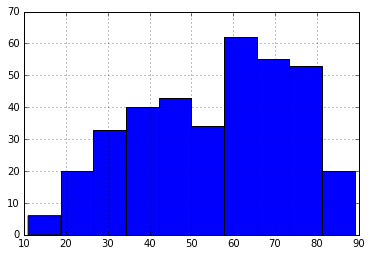

In [395]:
#kretanje temperatura kroz godinu
data.mean_temp.hist()

In [396]:
#kako je tip podataka za vrijeme string, ako zelimo baratati s datumima, moramo ih zapisati u odgovarajući oblik
from datetime import datetime
import scipy.interpolate as inter
import matplotlib.pyplot as plt
data.date = data.date.apply(lambda d: datetime.strptime(d, "%Y-%m-%d"))
data.index = data.date

In [397]:
#izvucemo trazene podatke o proljecu
proljece = data[data.date < datetime(2012,6,21)]
proljece = proljece[proljece.date >=datetime(2012,3,21)]
proljece = proljece.ix[:,0:4]
proljece.index = [x for x in range(0,92)]
proljece_svaki_drugi = proljece[proljece.index % 2 == 0]
proljece_svaki_treci = proljece[proljece.index % 3 == 0]
proljece_svaki_cetvrti = proljece[proljece.index % 4 == 0]

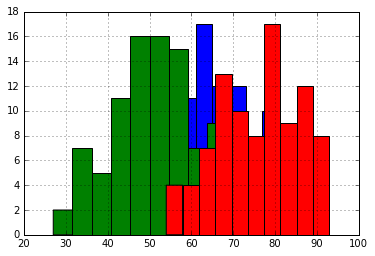

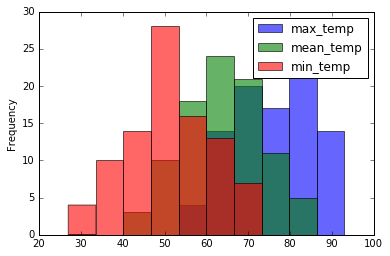

In [398]:
#histogram najmanjih, prosjecnih i najvecih temperatura koje se pojavljuju u proljece
proljece.mean_temp.hist()
proljece.min_temp.hist()
proljece.max_temp.hist()
plt.figure()
proljece.plot.hist(alpha = 0.6)

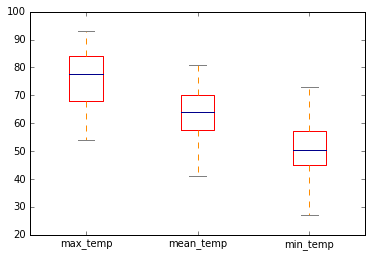

In [411]:
boja = dict(boxes='Red', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
proljece.plot.box(color=boja)

0.9436006388496827

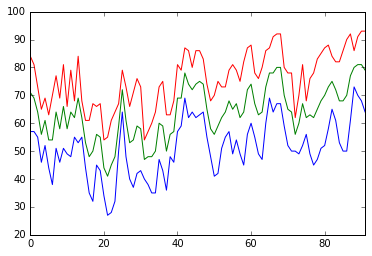

In [414]:
#linearna aproksimacija kretanja temperatura
proljece.min_temp.plot()
proljece.mean_temp.plot()
proljece.max_temp.plot()
proljece.mean_temp.corr(proljece.max_temp)

Sad ćemo vidjeti kako se neke aproksimacije ponašaju u odnosu na to koliko točaka imaju prilikom računanje aproksimacije.
Za primjer pogledat ćemo što se događa imamo podatke o svakom drugom, trećem i četvrtom danu. 

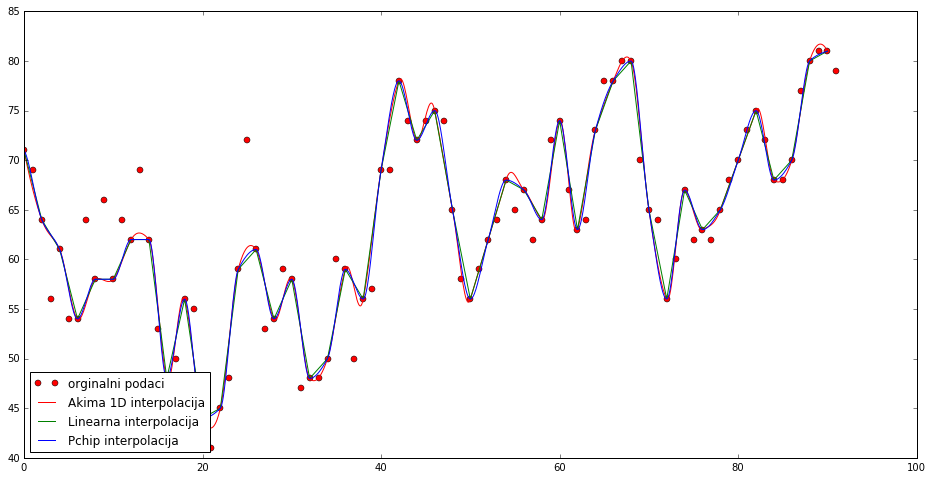

In [400]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(proljece.index, proljece.mean_temp, 'ro', label='orginalni podaci')


x = np.linspace(0,90,1000)
n = np.arange(0, 92, 2)

inter1 = inter.Akima1DInterpolator(n, proljece_svaki_drugi.mean_temp)
y_interp1 = inter1(x)

inter2 = inter.interp1d(n, proljece_svaki_drugi.mean_temp)
y_interp2 = inter2(x)

inter3 = inter.PchipInterpolator(n, proljece_svaki_drugi.mean_temp)
y_interp3 = inter3(x)

ax.plot(x, y_interp1, 'r', label='Akima 1D interpolacija')
ax.plot(x, y_interp2, 'g', label='Linearna interpolacija')
ax.plot(x, y_interp3, 'b', label='Pchip interpolacija')
ax.legend(loc=3);

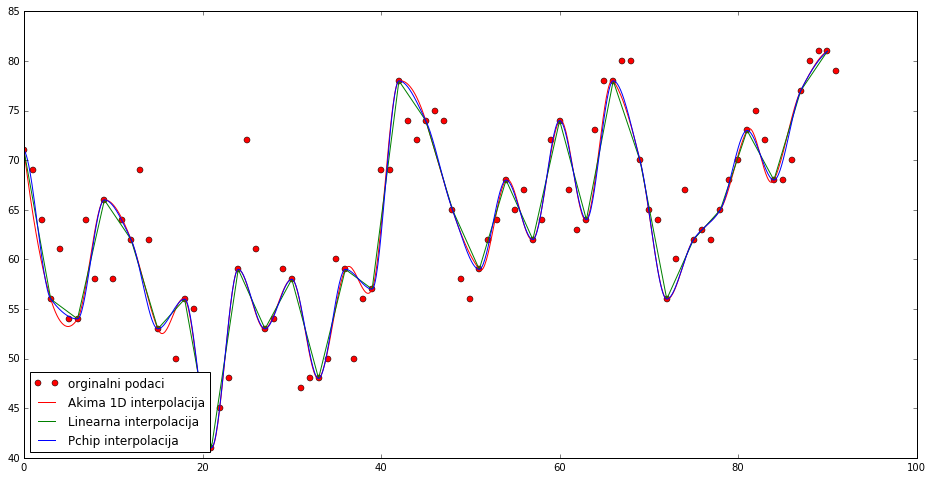

In [401]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(proljece.index, proljece.mean_temp, 'ro', label='orginalni podaci')


x = np.linspace(0,90,1000)
n = np.arange(0, 92, 3)

inter1 = inter.Akima1DInterpolator(n, proljece_svaki_treci.mean_temp)
y_interp1 = inter1(x)

inter2 = inter.interp1d(n, proljece_svaki_treci.mean_temp)
y_interp2 = inter2(x)

inter3 = inter.PchipInterpolator(n, proljece_svaki_treci.mean_temp)
y_interp3 = inter3(x)

ax.plot(x, y_interp1, 'r', label='Akima 1D interpolacija')
ax.plot(x, y_interp2, 'g', label='Linearna interpolacija')
ax.plot(x, y_interp3, 'b', label='Pchip interpolacija')
ax.legend(loc=3);


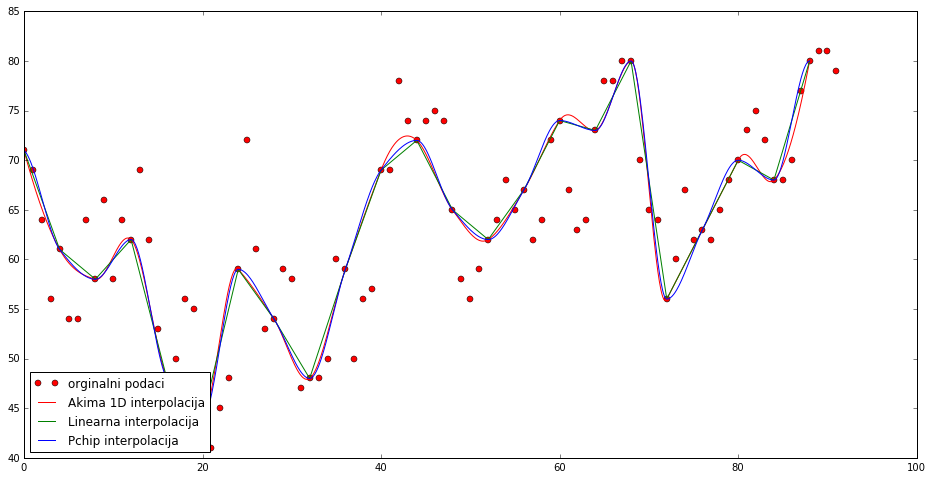

In [452]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(proljece.index, proljece.mean_temp, 'ro', label='orginalni podaci')


x = np.linspace(0,88,1000)
n = np.arange(0, 92, 4)

inter1 = inter.Akima1DInterpolator(n, proljece_svaki_cetvrti.mean_temp)
y_interp1 = inter1(x)

inter2 = inter.interp1d(n, proljece_svaki_cetvrti.mean_temp)
y_interp2 = inter2(x)

inter3 = inter.PchipInterpolator(n, proljece_svaki_cetvrti.mean_temp)
y_interp3 = inter3(x)

ax.plot(x, y_interp1, 'r', label='Akima 1D interpolacija')
ax.plot(x, y_interp2, 'g', label='Linearna interpolacija')
ax.plot(x, y_interp3, 'b', label='Pchip interpolacija')
ax.legend(loc=3);

Još jedan zanimljiv način interpolacije jest interpolacija sa splajnovima.  

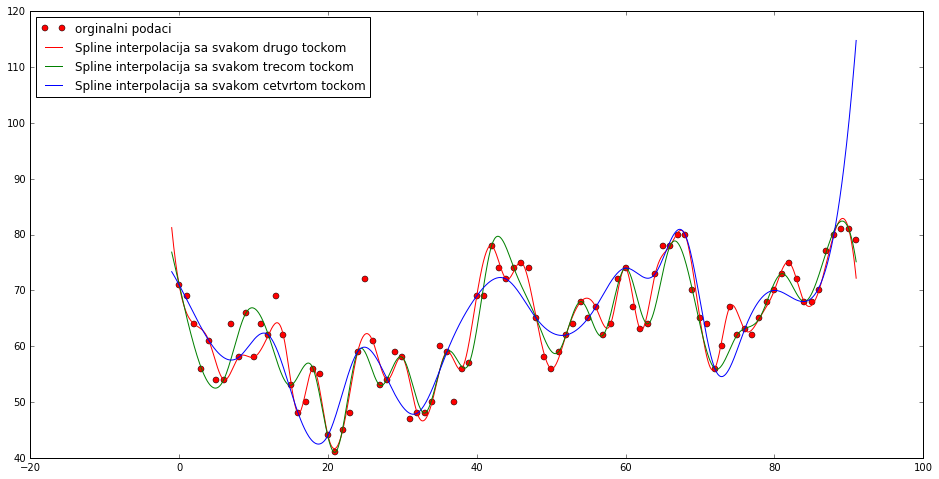

In [446]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(proljece.index, proljece.mean_temp, 'ro', label='orginalni podaci')


x = np.linspace(-1,91,1000)
n2 = np.arange(0, 92, 2)
n3 = np.arange(0, 92, 3)
n4 = np.arange(0, 92, 4)

inter1 = inter.InterpolatedUnivariateSpline(n2, proljece_svaki_drugi.mean_temp)
y_interp1 = inter1(x)

inter2 = inter.InterpolatedUnivariateSpline(n3, proljece_svaki_treci.mean_temp)
y_interp2 = inter2(x)

inter3 = inter.InterpolatedUnivariateSpline(n4, proljece_svaki_cetvrti.mean_temp)
y_interp3 = inter3(x)

ax.plot(x, y_interp1, 'r', label='Spline interpolacija sa svakom drugo tockom')
ax.plot(x, y_interp2, 'g', label='Spline interpolacija sa svakom trecom tockom')
ax.plot(x, y_interp3, 'b', label='Spline interpolacija sa svakom cetvrtom tockom')
ax.legend(loc=2);